# Optic flow connectivity analysis in FAFB

This script is about getting optic flow vectors in the medulla based on the main inputs of direction-selective cells in the medulla

In [1]:
# Importing some packages
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import pandas as pd
import seaborn as sns
import os
from fafbseg import flywire

C:\Users\smolina\Anaconda3\envs\EM2\lib\site-packages\blessed\terminal.py:183: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


In [2]:
# Custom functions
def combine_xyz(df):
    """
    Combines separated x, y and z column into one, changes units and adds new column names for
    generating a neuroglancer link with function nglui.statebuilder.helpers.make_synapse_neuroglancer_link

    Args:
        pandas data frame containing x,y and z as columns of the same length

    Returns:
        same pandas data frame containing a new column with [x/4,y/4,z/40] lists
    """
    # Generating the single column

    post_pt_position = []
    for x,y,z in zip(df['post_x'].tolist(),df['post_y'].tolist(),df['post_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        post_pt_position.append(temp_ls)

    pre_pt_position = []
    for x,y,z in zip(df['pre_x'].tolist(),df['pre_y'].tolist(),df['pre_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        pre_pt_position.append(temp_ls)

    #Adding new columns and names
    df['post_pt_position'] = post_pt_position
    df['pre_pt_position'] = pre_pt_position
    #Changing column names
    df.rename(columns={'pre': 'pre_pt_root_id', 'post': 'post_pt_root_id'}, inplace=True)

# 1. Getting the data of interest

In [3]:
# Some user parameters
cell_for_grid = 'Mi1'

In [4]:
# Importing data from Codex
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_columns.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_data = pd.read_csv(filePath, compression='gzip')
columns_id_data.rename(columns={"cell id": "root_id","cell type": "cell_type","column id": "column_id" }, inplace= True)

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_metadata.csv.gz'
filePath = os.path.join(dataPath,fileName)
metadata = pd.read_csv(filePath, compression='gzip')

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_connections.csv.gz'
filePath = os.path.join(dataPath,fileName)
connections = pd.read_csv(filePath, compression='gzip')
connections.rename(columns={"from cell id": "from_cell_id","to cell id": "to_cell_id" }, inplace= True)

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'column_assignment.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_coordinates = pd.read_csv(filePath, compression='gzip')

#Brief overview:
print('\n----------------- column data -----------------:\n')
print(columns_id_data)

print('\n------------------ metadata ------------------:\n')
print(metadata)
print('\n----------------- connections ----------------:\n')
print(connections)
print('\n----------------- coordinates ----------------:\n')
print(columns_id_coordinates)


----------------- column data -----------------:

                  root_id cell_type column_id
0      720575940596125868       T5c        97
1      720575940599333574       Tm1       355
2      720575940599457990       T4b       247
3      720575940599459782       T5b       513
4      720575940599704006       T5a       331
...                   ...       ...       ...
23447  720575940661201025        R8       701
23448  720575940661224065       T4a       390
23449  720575940661245825        C3       183
23450  720575940661264001        C3        38
23451  720575940661284993        R8       694

[23452 rows x 3 columns]

------------------ metadata ------------------:

                 attribute    value
0   number of cells mapped    22578
1  synapses inside columns  1381915
2   synapses cross columns   811545

----------------- connections ----------------:

              from_cell_id          to_cell_id  synapses
0       720575940596125868  720575940622955561         2
1       72057

## 1.1 Combining the data of interest into useful data frames

In [5]:
## Completing the "connections" data frame

connections_extended = connections.copy()

# Merge to add from_cell_type
connections_extended = connections_extended.merge(
    columns_id_data[['root_id', 'cell_type','column_id']],
    how='left',
    left_on='from_cell_id',
    right_on='root_id'
).rename(columns={'cell_type': 'from_cell_type','column_id': 'from_column_id'}).drop(columns=['root_id'])

# Merge to add to_cell_type
connections_extended = connections_extended.merge(
    columns_id_data[['root_id', 'cell_type','column_id']],
    how='left',
    left_on='to_cell_id',
    right_on='root_id'
).rename(columns={'cell_type': 'to_cell_type','column_id': 'to_column_id'}).drop(columns=['root_id'])

# Display the updated connections data frame
print(connections_extended)

              from_cell_id          to_cell_id  synapses from_cell_type  \
0       720575940596125868  720575940622955561         2            T5c   
1       720575940599333574  720575940617904614         7            Tm1   
2       720575940599333574  720575940629129692        22            Tm1   
3       720575940599333574  720575940612157041        11            Tm1   
4       720575940599333574  720575940609269771         4            Tm1   
...                    ...                 ...       ...            ...   
270851  720575940661264001  720575940613285034         3             C3   
270852  720575940661264001  720575940647104291        87             C3   
270853  720575940661264001  720575940638965155        17             C3   
270854  720575940661284993  720575940628173394         3             R8   
270855  720575940661284993  720575940624106948         7             R8   

       from_column_id to_cell_type to_column_id  
0                  97          T5c          443  

In [6]:
connections_extended.from_cell_type.unique()

array(['T5c', 'Tm1', 'T4b', 'T5b', 'T5a', 'T4a', 'Tm9', 'Mi9', 'T4c',
       'T5d', 'T4d', 'Tm3', 'T3', 'T2a', 'L1', 'T2', 'Mi4', 'Mi1', 'Tm2',
       'Tm4', 'C2', 'L4', 'Tm20', 'L5', 'C3', 'Tm21', 'L3', 'L2', 'R7',
       'T1', 'R8'], dtype=object)

# 2. Creating the hexagonal grid

## 2.1 Getting the cells of reference (usually Mi1s) for creating a 2D lattice

In [7]:
# Looking deeply at the match between individual cells and individual columns
cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_for_grid]
number_unique_cells = len(cells_columns['root_id'].unique())
number_unique_columns = len(cells_columns['column_id'].unique())-1 #-1 to compensate for "not assigned label"

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')

# Addining column coordinates information
df_grid =  pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
print(f'Final df_grid length: {len(df_grid)}')
display(df_grid.head())

Total number of unique cells: 796
Total number of unique columns: 795
Missmatch: 1
Number of duplicates / cells not assigned to columns: 0
Filtered data length: 796
Final df_grid length: 796


root_id cell_type column_id   p   q  x   y
0  720575940603042272       Mi1         1  12   1  6  13
1  720575940603200428       Mi1         2   9  -7  8   2
2  720575940603327916       Mi1         3 -12   0 -6 -12
3  720575940603935334       Mi1         4  -6 -15  5 -21
4  720575940604151008       Mi1         6   0  -4  2  -4

## 2.2 Importing other more data about the cells of interest

In [8]:
# Importing data from Codex
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'labels.csv.gz'
filePath = os.path.join(dataPath,fileName)
labels_data = pd.read_csv(filePath, compression='gzip')

In [9]:
df2 = pd.merge(labels_data, columns_id_data, on='root_id', how='outer')
filtered_df2  = df2.drop_duplicates(subset='root_id', keep='first').copy()
mi1_df2 = filtered_df2[filtered_df2['cell_type'] == 'Mi1'].copy()
display(mi1_df2.head())

root_id                                             label  \
192  720575940603042272  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   
238  720575940603200428  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   
272  720575940603327916  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   
631  720575940603935334  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   
782  720575940604151008  Mi1; Medullary intrinsic neuron 1; FBbt_00003776   

     user_id                position  supervoxel_id  label_id  \
192    392.0  [739864 206272  81960]   8.331962e+16   76738.0   
238    392.0  [709316 297120  66680]   8.282855e+16   77514.0   
272    392.0  [833308 358980 202680]   8.494071e+16   76614.0   
631    392.0  [684784 347004 123280]   8.240723e+16   76740.0   
782    392.0  [771472 320404  81080]   8.388449e+16   77389.0   

            date_created       user_name user_affiliation cell_type column_id  
192  2023-01-31 22:14:43  Krzysztof Kruk          Eyewire       Mi1         1  
238  2023-02-01 14:00:22  Krzysztof Kruk          Eyewire       Mi1         2  
272  2023-01-31 22:14:34  Krzysztof Kruk          Eyewire       Mi1         3  
631  2023-01-31 22:14:44  Krzysztof Kruk          Eyewire       Mi1         4  
782  2023-02-01 14:00:10  Krzysztof Kruk          Eyewire       Mi1         6

In [10]:
#checking numbers with Mi1 example
print('Number of unique Mi1 ids in df2: ')
print(len(df2[df2['cell_type'] == 'Mi1'].root_id.unique()))
print('Number of  Mi1 ids in filtered_df2: ')
print(len(filtered_df2[filtered_df2['cell_type'] == 'Mi1'].root_id))


Number of unique Mi1 ids in df2: 
796
Number of  Mi1 ids in filtered_df2: 
796


In [11]:
# Getting Mi1s positions (soma locations)

# Convert positions to NumPy array for easier manipulation
positions_somas = np.array(mi1_df2.position.values) # These are apparently soma locations!
positions_somas = np.array([list(map(int, pos.strip('[]').split())) for pos in positions_somas])

In [ ]:
## Getting Mi1 positions (terminals)

'''
All in a loop across mi1 cells:
1. Getting pre-synaptic sites
2. PCA to get the depth axis of each Mi1
3. Select the last points belonging to layer M9-10
4. Calculate a centroid
5. Define this centroid as the Mi1 terminal location
'''
# Getting pre-synaptic sites
terminal_position_ls = []
curr_id_ls = mi1_df2.root_id.tolist()
output_df2 = flywire.synapses.get_synapses(curr_id_ls, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True)

Using materialization version 783.


Fetching synapses:   0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
# PCA to get the depth axis of each Mi1
combine_xyz(output_df2)
for root_id in mi1_df2.root_id:
    # Getting single Mi1 re synaptic sites
    curr_df2 = output_df2[output_df2.pre_pt_root_id == int(root_id)]
    positions_pre_syn = np.array(curr_df2.pre_pt_position.values)
    positions_pre_syn = np.array([list(map(int, pos.strip('[]').split())) for pos in positions_pre_syn])

    #Doing PCA
    
    pass

# Seb coding here

In [ ]:
output_df2.head()

In [ ]:
# Quick visualization

import plotly.graph_objs as go

# Extract x, y, z coordinates
x = positions_somas[:, 0]
y = positions_somas[:, 1]
z = positions_somas[:, 2]

# Create the 3D scatter plot
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(size=5, color='blue')
)

layout = go.Layout(
    title='3D Scatter Plot of Positions',
    scene=dict(
        xaxis_title='X Position',
        yaxis_title='Y Position',
        zaxis_title='Z Position'
    )
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()




In [ ]:
# Checking positions relative to the medulla neuropile

import navis
neurpile_mesh = 'ME_L'

#For top view
mesh_azim =16# -18 for ME_R, 16 (600) for ME_L
mesh_elev = -50 # -148 for ME_R, -50 (-489) for ME_L 

# Extract x, y, z coordinates
x = positions_somas[:, 0]
y = positions_somas[:, 1]
z = positions_somas[:, 2]

# Create a 3D scatter plot

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')

#Plot the mesh
OL_R = flywire.get_neuropil_volumes([neurpile_mesh]) #['ME_R','LO_R','LOP_R']
navis.plot2d([OL_R], method='3d_complex', ax=ax,view=(172, 51),scalebar = '20 um')

ax.azim = mesh_azim
ax.elev = mesh_elev

# Plot the data
ax.scatter(x, y, z, c='b', marker='o')

# Set labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')

# Set title
ax.set_title('3D Scatter Plot of Positions')

plt.show()

## 2.3 Getting the cells of interest (usually a T4 subtype) for optic flow analysis

In [9]:
# Looking deeply at the match between individual cells and individual columns
cell_of_interest = 'T4a'
cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_of_interest]
number_unique_cells = len(cells_columns['root_id'].unique())
number_unique_columns = len(cells_columns['column_id'].unique())-1 #-1 to compensate for "not assigned label"

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')

# Addining column coordinates information
df =  pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
print(f'Final df length: {len(df)}')
display(df.head())

# Filtering the connections_extended data frame:
connections_extended_cell_of_interest = connections_extended[connections_extended.to_cell_type == cell_of_interest].copy()
print('\nTotal number of unique cells and columns must fit with previous data sets:\n')
len_cells_in_connections_extended = len(connections_extended_cell_of_interest.to_cell_id.unique())
len_columns_in_connections_extended = len(connections_extended_cell_of_interest.to_column_id.unique())  -1# -1 to compensate for "not assigned label"
print(f'Connections_extended num of cells / columns: {len_cells_in_connections_extended} / {len_columns_in_connections_extended}')
display(connections_extended_cell_of_interest.head())

# Checking connections from a cell of interest
from_cell_of_interest = 'Mi4'
len_connected_cells = len(connections_extended_cell_of_interest[connections_extended_cell_of_interest.from_cell_type == from_cell_of_interest].to_cell_id.unique())
len_connected_columns = len(connections_extended_cell_of_interest[connections_extended_cell_of_interest.from_cell_type == from_cell_of_interest].to_column_id.unique())
print(f'\nTotal number of unique cells / columns connected with {from_cell_of_interest}: {len_connected_cells} / {len_connected_columns} \n')
display(connections_extended_cell_of_interest[connections_extended_cell_of_interest.from_cell_type == from_cell_of_interest].head())


Total number of unique cells: 737
Total number of unique columns: 725
Missmatch: 12
Number of duplicates / cells not assigned to columns: 12
Filtered data length: 725
Final df length: 725


root_id cell_type column_id  p   q  x   y
0  720575940599755718       T4a       741 -4  -8  2 -12
1  720575940600101641       T4a       487 -2   1 -1  -1
2  720575940600143369       T4a       662 -3   2 -2  -1
3  720575940600547529       T4a       727 -4  10 -7   6
4  720575940603491957       T4a       391 -6   3 -4  -3


Total number of unique cells and columns must fit with previous data sets:

Connections_extended num of cells / columns: 737 / 725


from_cell_id          to_cell_id  synapses from_cell_type  \
37   720575940599457990  720575940614620381         2            T4b   
60   720575940599755718  720575940640779984         3            T4a   
64   720575940599755718  720575940626967311         2            T4a   
99   720575940600101641  720575940634499832         2            T4a   
101  720575940600101641  720575940621551220         2            T4a   

    from_column_id to_cell_type to_column_id  
37             247          T4a          244  
60             741          T4a          634  
64             741          T4a          530  
99             487          T4a          372  
101            487          T4a          181


Total number of unique cells / columns connected with Mi4: 664 / 655 



from_cell_id          to_cell_id  synapses from_cell_type  \
313   720575940602943968  720575940627598852         5            Mi4   
316   720575940602943968  720575940619209408         7            Mi4   
1350  720575940604209580  720575940610253410         3            Mi4   
2590  720575940604941024  720575940605803744         3            Mi4   
2591  720575940604941024  720575940649880441         4            Mi4   

     from_column_id to_cell_type to_column_id  
313             205          T4a          369  
316             205          T4a          137  
1350            550          T4a          236  
2590            526          T4a          549  
2591            526          T4a          656

# 3. Generating the 2D (hexagonal) grid/lattice

In [10]:
'''

important tasks to be done:

Refine the space between hexagons in the x-axis. 
More space is needed in between hexagons to have the same as in the other axis after the shift to get the honeycomb-like lattice.

'''

'\n\nimportant tasks to be done:\n\nRefine the space between hexagons in the x-axis. \nMore space is needed in between hexagons to have the same as in the other axis after the shift to get the honeycomb-like lattice.\n\n'

In [11]:
## Custom functions for creating the 2d lattice

def plot_hex_grid(x, y, hex_size=1.0, spacing=1.5, fig_size=(10, 10), labels=None, label_type='column_id', text_size=10):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_aspect('equal')
    
    hexagons = []
    
    # Function to calculate vertices of hexagon
    def hexagon_vertices(x_center, y_center):
        angles = np.linspace(0, 2*np.pi, 7) + np.pi/2  # Add pi/8 to rotate by 45 degrees
        vertices = [(x_center + hex_size * np.cos(angle), y_center + hex_size * np.sin(angle)) for angle in angles]
        return vertices
    
    # Plot hexagons
    for i in range(len(x)):
        vertices = hexagon_vertices(x[i], y[i])
        hexagon = Polygon(vertices, edgecolor='black', linewidth=1, facecolor='none')
        ax.add_patch(hexagon)
        hexagons.append(hexagon)
        
        # Determine label based on label_type
        if label_type == 'manual_labels' and labels:
            label = labels[i]
        elif label_type == 'xy':
            label = f'({x[i]}, {y[i]})'
        else:
            label = ''
        
        # Add label in the center of the hexagon
        if label:
            x_center = x[i]
            y_center = y[i]
            ax.text(x_center, y_center, label, ha='center', va='center', fontsize=text_size)
    
    # Set limits based on the hexagon positions
    ax.set_xlim(min(x) - hex_size - spacing, max(x) + hex_size + spacing)
    ax.set_ylim(min(y) - hex_size - spacing, max(y) + hex_size + spacing)
    
    ax.autoscale_view()
    
    return fig, ax, hexagons

def draw_vector(ax, x_start, y_start, x_end, y_end, linewidth=2, head_size=0.5, **kwargs):
    """Draw an arrow (vector) from one (x, y) coordinate to another with specified linewidth and arrowhead size."""
    arrow_style = f'->,head_width={head_size},head_length={head_size * 1.5}'
    arrow_style = f'-|>,head_width={head_size},head_length={head_size * 1.5}'
    ax.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                arrowprops=dict(arrowstyle=arrow_style, linewidth=linewidth, fill=True, **kwargs))


def calculate_new_p_values(original_x, original_y, start_key=-16, end_key=17, relative_change=0.5, in_space=0):
    shift_dict = {}

    # Iterate through the range from start_key to end_key (inclusive)
    for i in range(start_key, end_key + 1):
        # Calculate the corresponding value based on relative_change
        value = (i - start_key) * relative_change
        # Assign the key-value pair to the dictionary
        shift_dict[i] = value

    # Initialize a list to store the new_x values
    new_x_values = []

    # Iterate through each pair of original_x and original_y
    for x, y in zip(original_x, original_y):
        if y in shift_dict:
            # Get the corresponding relative_change from shift_dict
            relative_change = shift_dict[y]
            # Calculate the new_x value
            new_x = x - relative_change
            # Append the new_x value to the list
            new_x_values.append(new_x)
        else:
            # Handle case where y is not found in shift_dict (optional)
            # You may choose to skip these or handle them differently
            new_x_values.append(x)  # Keep original x value if no match found


    return new_x_values


def add_space_in_between(num_negatives, num_positives, space, key_list):
    # Generate negative numbers
    negative_numbers = [-space * i for i in range(num_negatives, 0, -1)]
    
    # Generate positive numbers
    positive_numbers = [space * i for i in range(1, num_positives + 1)]
    
    # Combine the lists with 0 in between
    generated_list = negative_numbers + [0] + positive_numbers
    
    # Create the original range list including 0
    original_range = list(range(-num_negatives, num_positives + 1))
    
    # Create a dictionary with original_range as keys and generated_list as values
    space_dict = {}
    
    # Fill the dictionary with corresponding values
    for i, key in enumerate(original_range):
        if i < len(generated_list):
            space_dict[key] = generated_list[i]
        else:
            space_dict[key] = None  # Assign None if there's no corresponding value

    # Generate a new list based on the key_list and space_dict
    new_list = [space_dict.get(key, None) for key in key_list]
    
    return new_list



In [12]:
## Preparing data to plot
#Important axis across the eye/medulla ( in terms of p,q coordinates)
'''
The ommatidia directions are well described by a hexagonal grid that we then aligned to the medulla column grid using 
the equator (+h) and central meridian (+v) as global landmarks
'''
h_x_ls = list(range(-8,8+1,1))
h_y_ls = list(range(8,-8-1,-1))
h = list(zip(h_x_ls,h_y_ls))

v_x_ls = list(range(-14,15+1,1))
v_y_ls = v_x_ls
v = list(zip(v_x_ls,v_y_ls))

p_y_ls = list(range(14,-13-1,-1))
p_x_ls = [0]* len(p_y_ls)
p = list(zip(p_x_ls,p_y_ls))

q_x_ls = list(range(-14,14+1,+1))
q_y_ls = [0]* len(q_x_ls)
q = list(zip(q_x_ls,q_y_ls))

'''
Seb, it would be good to calculate a new _new_x_ls and new_? 
(e.g., new_q_x_ls and new_q) using the function calculate_new_p_values
'''


# Given coordinates and labels (data)
# Original coordinates
original_p = df_grid.p.tolist()
original_q = df_grid.q.tolist()

# Shifting and spacing x coordinates
_relative_change = 0.58
_space = 1.15
spaced_original_p  = add_space_in_between(18, 18, _space, original_p)
new_p_values = calculate_new_p_values(spaced_original_p, original_q, start_key=-16, end_key=17, relative_change=_relative_change, in_space=0)
df_grid['new_p'] = new_p_values

# "manual_labels" column ids
labels = df_grid.column_id.tolist() 

# "manual_labels" original coordinates
#labels = list(zip(original_p, original_q)) 
#labels = [f"({x}, {y})" for x, y in labels]



### Ploting a regular grid

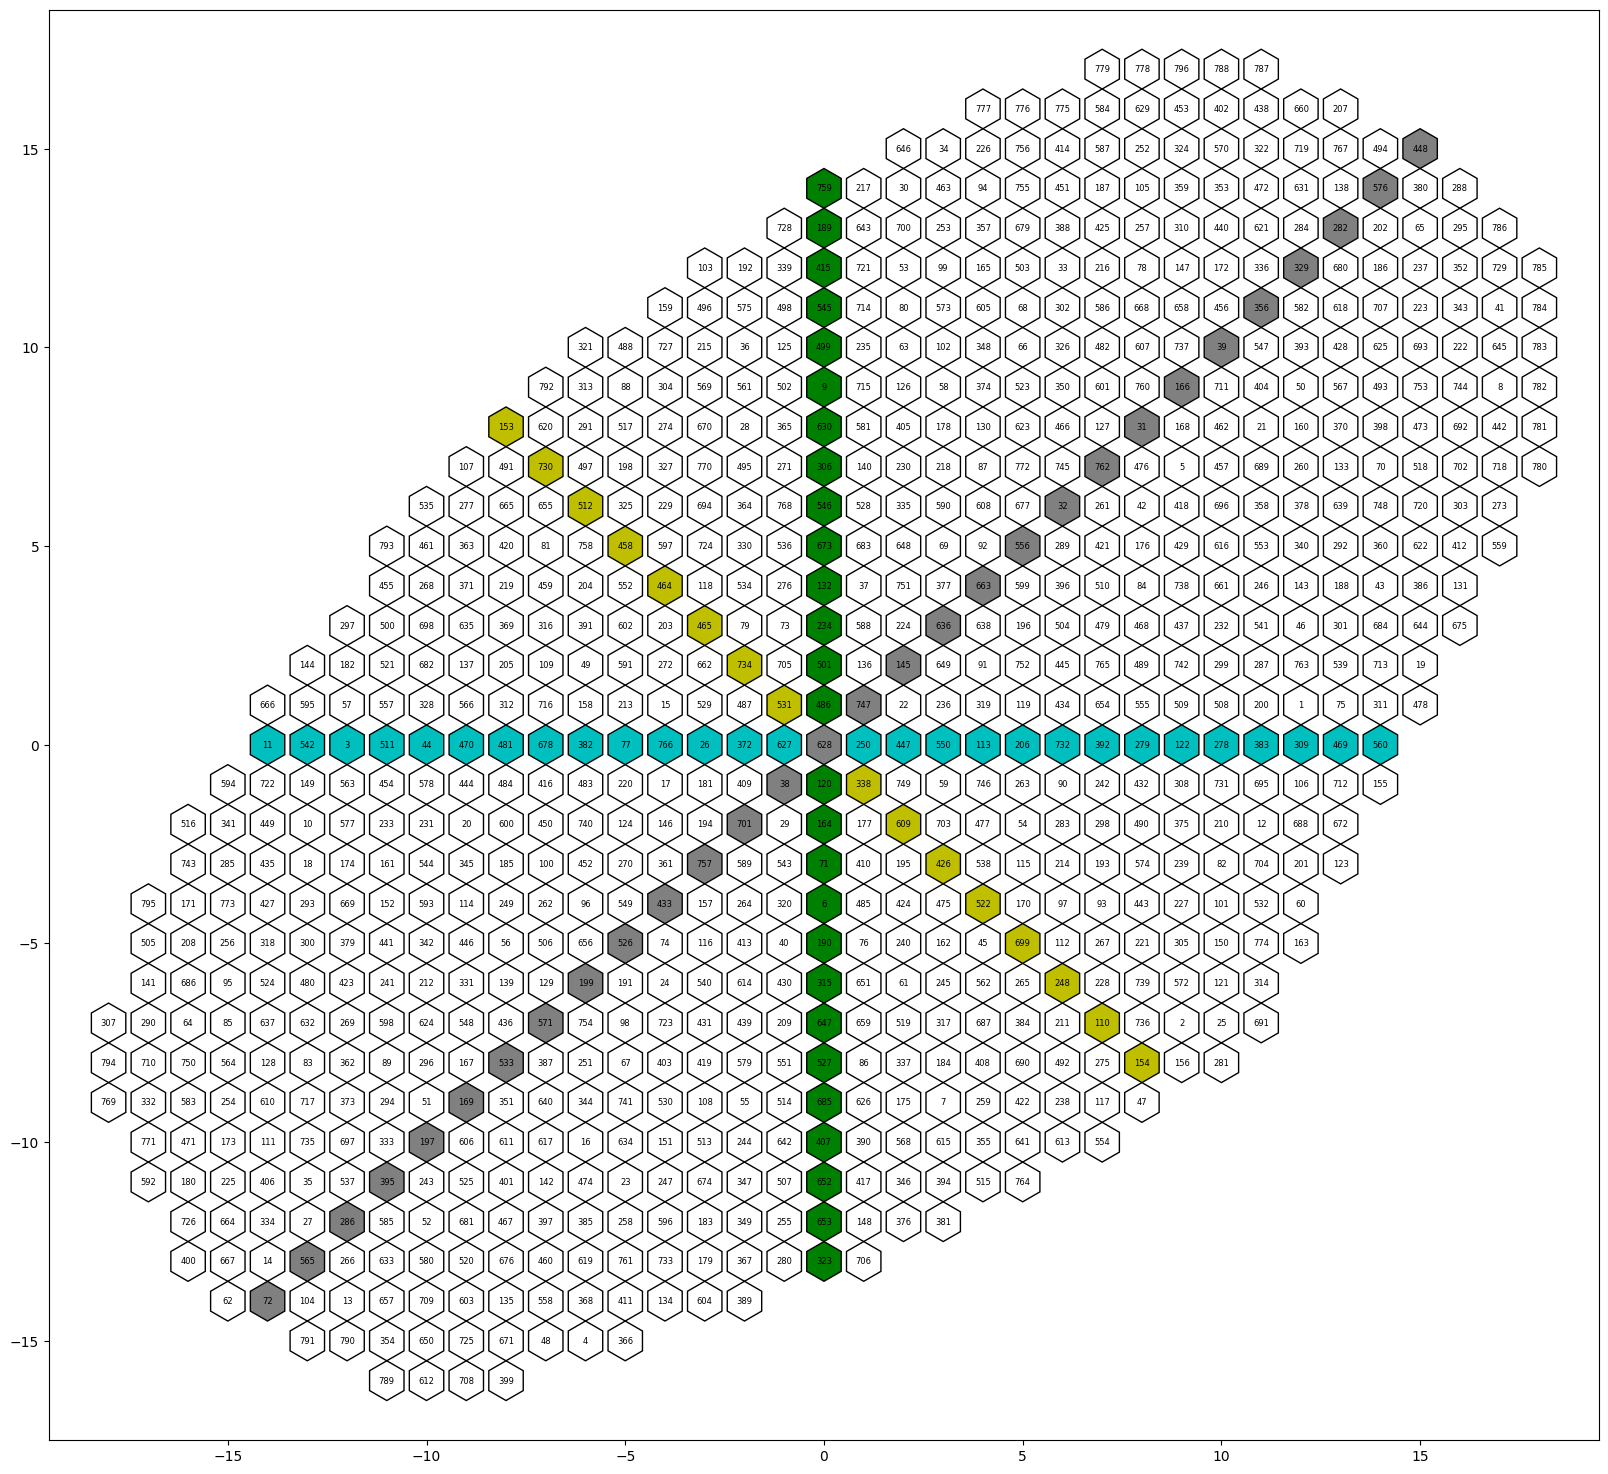

In [13]:
## Plotting on the 2D lattice: check access to each point and axis
fig, ax, hexagons = plot_hex_grid(original_p, original_q, hex_size=0.5, spacing=1.0, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition
for p_x, p_y in p:
    color_in_p = p_x
    color_in_q = p_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('g')

for q_x, q_y in q:
    color_in_p = q_x
    color_in_q = q_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('c')
            

for h_x, h_y in h:
    color_in_p = h_x
    color_in_q = h_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('y')


for v_x, v_y in v:
    color_in_p = v_x
    color_in_q = v_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('grey')





### Ploting hexagonal grids

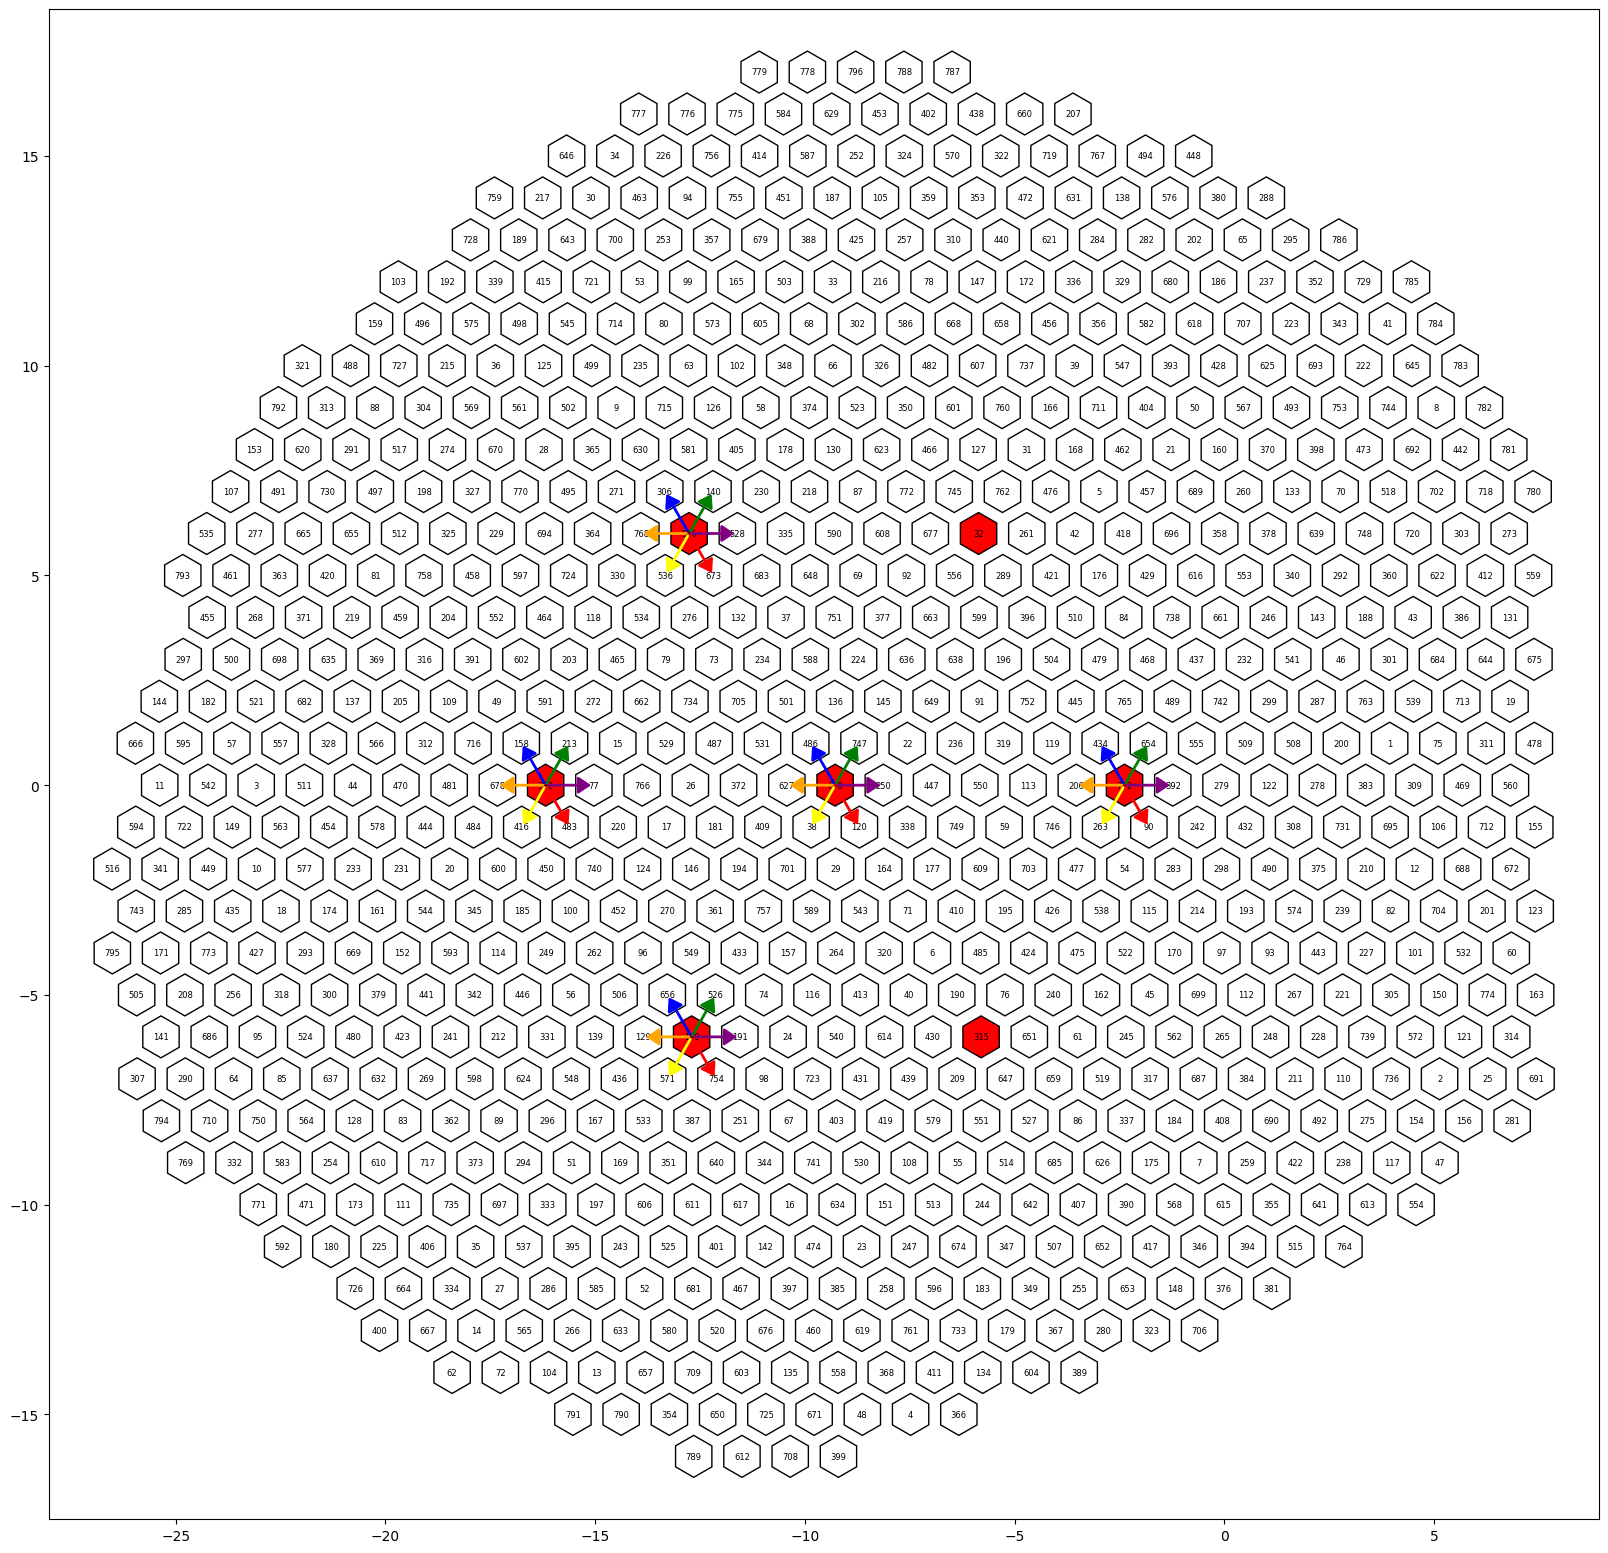

In [14]:
# _relative_change = 0.58
# _space = 1.15
# spaced_original_p  = add_space_in_between(18, 18, _space, original_p)
# new_p_values = calculate_new_p_values(spaced_original_p, original_q, start_key=-16, end_key=17, relative_change=_relative_change, in_space=_space)
# df_grid['new_p'] = new_p_values

## Plotting on the 2D lattice: check access to each point and axis
fig, ax, hexagons = plot_hex_grid(new_p_values, original_q, hex_size=0.5, spacing=1.0, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition

color_in_p = 0
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = 0
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = 0
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = 6
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = 0
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = -6
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = 6
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = 0
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = -6
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = 0
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = 6
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = 6
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = -6
color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
color_in_p = color_in_p[0]
color_in_q = -6
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

# Draw vector from hexagon to hexagon
# Choose column_ids
start_ids = ([628]*6) + ([546]*6) + ([732]*6) + ([382]*6) + ([199]*6)
end_ids = [120, 486, 747,38,250,627] + [673,306,140,536,528,768] + [90,434,654,263,392,206] + [483,158,213,416,77,678] + [754,656,526,571,191,129]
color_ls = ["red", "blue", "green", "yellow", "purple", "orange"]*5
start_coords_ls = []
end_coords_ls = []
for start_id, end_id in zip(start_ids, end_ids):
    start_id_p = df_grid[df_grid.column_id == str(start_id)].new_p.values[0]
    start_id_q = df_grid[df_grid.column_id == str(start_id)].q.values[0]
    start_coords_ls.append((start_id_p,start_id_q))

    
    end_id_p = df_grid[df_grid.column_id == str(end_id)].new_p.values[0]
    end_id_q = df_grid[df_grid.column_id == str(end_id)].q.values[0]
    end_coords_ls.append((end_id_p,end_id_q))

    #Drawing vectors
i = 0
for start_coord, end_coord in zip(start_coords_ls,end_coords_ls):
    # Find the coordinates of the start and end hexagons
    x_start = start_coord[0]
    y_start = start_coord[1]
    
    x_end = end_coord[0]
    y_end = end_coord[1]

    draw_vector(ax, x_start, y_start, x_end, y_end, color=color_ls[i])
    #print(f'Color: {color_ls[i]}, end: ({x_end},{y_end})')
    i += 1
    


plt.show()

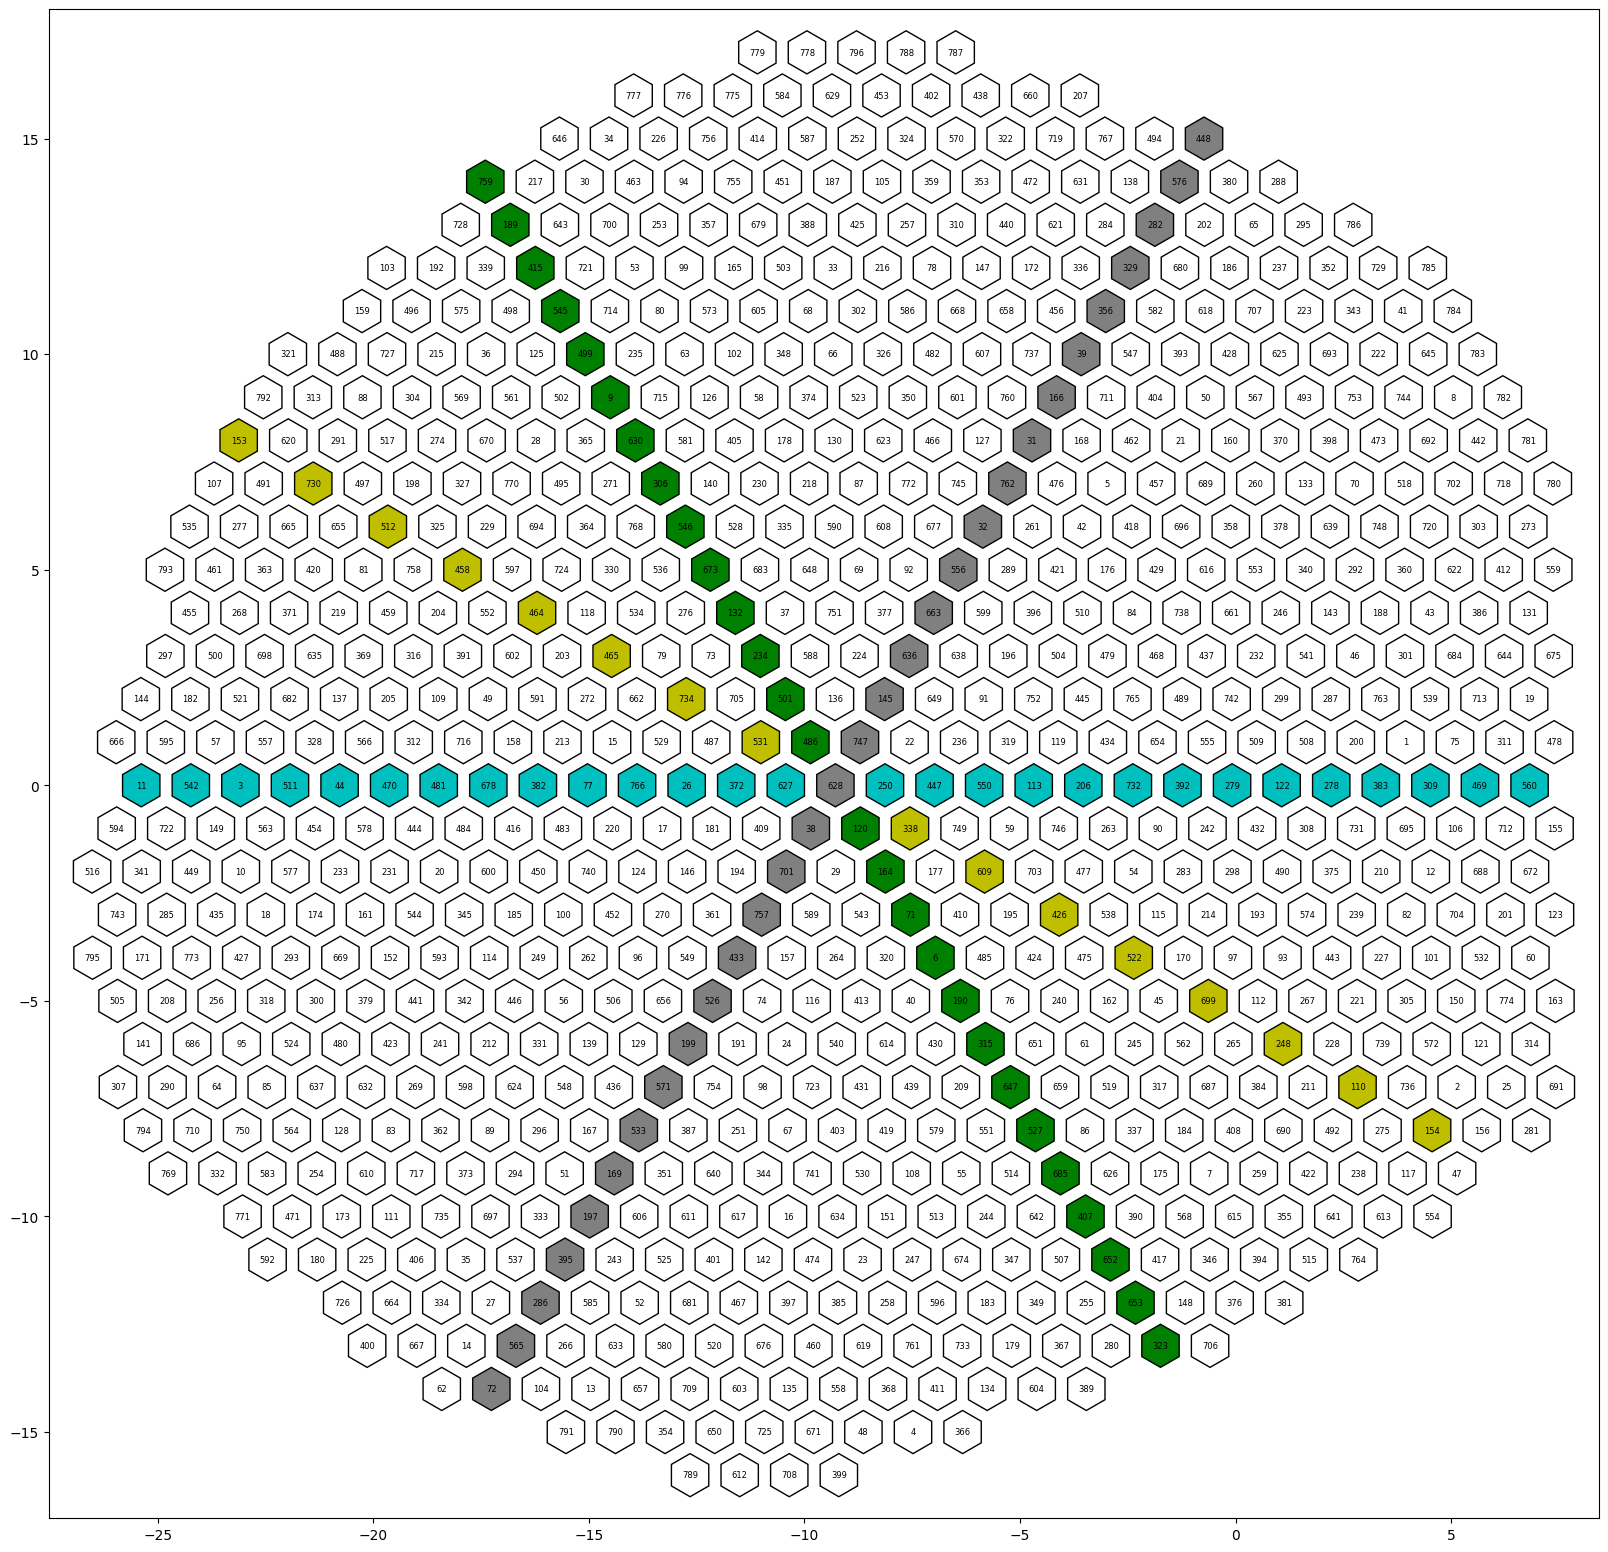

In [15]:

# _relative_change = 0.58
# _space = 1.15
# spaced_original_p  = add_space_in_between(18, 18, _space, original_p)
# new_p_values = calculate_new_p_values(spaced_original_p, original_q, start_key=-16, end_key=17, relative_change=_relative_change, in_space=_space)
# df_grid['new_p'] = new_p_values

## Plotting on the 2D lattice: look at the reference axis (h, v, p, q) 
fig, ax, hexagons = plot_hex_grid(new_p_values, original_q, hex_size=0.5, spacing=0.5, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition
new_p_x_ls = []
for p_x, p_y in p:
    color_in_p = p_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = p_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('g')
            new_p_x_ls.append(new_p_pos[0])
            
new_q_x_ls = []
for q_x, q_y in q:
    color_in_p = q_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = q_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('c')
            new_q_x_ls.append(new_p_pos[0])
            
new_h_x_ls = []
for h_x, h_y in h:
    color_in_p = h_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = h_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('y')
            new_h_x_ls.append(new_p_pos[0])

new_v_x_ls = []
for v_x, v_y in v:
    color_in_p = v_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = v_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('grey')
            new_v_x_ls.append(new_p_pos[0])
            
# Draw reference lines

'''
Needed? I am showing them now by coloring the hexagons
'''


plt.show()

# 4. Plotting optic flow data on the grid/lattice

The logic is to obtain:
1) the home column based on column_id assignment, 
2) the column_id of the highly connected intracolumnar input cells via absolute synaptic counts
3) draw vectors to/from home column from/to those input-cell columns

In [16]:
## Be aware that these two initial data frames do not have the same unique IDs
## Ideally they should. Think of replacing the one that has less

print(f'"connections" df length: {len(connections.to_cell_id.unique())}')
print(f'"columns_id_data" df length: {len(columns_id_data.root_id.unique())}')

"connections" df length: 22824
"columns_id_data" df length: 23452


In [145]:
## Ploting setting

color_dict = {'T4a':'g','T4b':'b', 'T4c':'r', 'T4d':'y'}
correlator = 'BL' # 'BL' for Barlow-Levick, 'HR' for Hassenstein-Reichert, 'HR-BL' for the combination
to_cell_of_interest = 'T4b'

In [146]:
## Getting inputs of the cell of interest implementing the BL correlator
BL_cell_of_interest = 'Mi4'

cell_of_interest_inputs = connections_extended[(connections_extended.to_cell_type == to_cell_of_interest) & (connections_extended.from_cell_type == BL_cell_of_interest)].copy()
num_of_cells = len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_cell_id.unique())
num_of_columns = len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_column_id.unique())
print(f'Number of unique postsynaptic cells / columns of interest: {num_of_cells} / {num_of_columns}')

# Sort by to_cell_id and synapses in descending order
cell_of_interest_inputs_sorted = cell_of_interest_inputs.sort_values(by=['to_cell_id', 'synapses'], ascending=[True, False])

# Group by to_cell_id and take the first row for each group (highest synapse value)
BL_unique_highest_inputs = cell_of_interest_inputs_sorted.drop_duplicates(subset='to_cell_id', keep='first').copy()

#Dropping 'not assigned' rows
BL_unique_highest_inputs_filtered = BL_unique_highest_inputs[BL_unique_highest_inputs.to_column_id != 'not assigned'].copy()

# Find the duplicates with the same to_cell_id and synapse value
BL_duplicates_in_highest_inputs = cell_of_interest_inputs_sorted[cell_of_interest_inputs_sorted.duplicated(subset=['to_cell_id', 'synapses'], keep=False)]

# Changing column names for clarity
BL_unique_highest_inputs_filtered.rename(columns={'from_cell_id': 'BL_cell_id', 'from_cell_type': 'BL_cell_type', 'from_column_id': 'BL_column_id', 
                                                  'to_cell_id': 'home_cell_id', 'to_cell_type': 'home_cell_type','to_column_id': 'home_column_id'}, inplace = True)
# Comvertions to strings
BL_unique_highest_inputs_filtered['BL_cell_id'] = BL_unique_highest_inputs_filtered['BL_cell_id'].apply(str)


# Display the resulting data frames
print("\nUnique Highest Inputs:")
display(BL_unique_highest_inputs_filtered.head())
print(f'\n"BL_unique_highest_inputs" df length: {len(BL_unique_highest_inputs_filtered)}')



#print("\nDuplicates in Highest Inputs:")
#print(BL_duplicates_in_highest_inputs.head())
#print(len(BL_duplicates_in_highest_inputs))

Number of unique postsynaptic cells / columns of interest: 656 / 652

Unique Highest Inputs:


BL_cell_id        home_cell_id  synapses BL_cell_type  \
77718   720575940619744728  720575940599457990         3          Mi4   
122122  720575940623829738  720575940601206499         5          Mi4   
106101  720575940622334121  720575940601672201         2          Mi4   
309     720575940602943968  720575940603498869         7          Mi4   
87219   720575940620636225  720575940604180140         4          Mi4   

       BL_column_id home_cell_type home_column_id  
77718            23            T4b            247  
122122          336            T4b            356  
106101          562            T4b            265  
309             205            T4b            312  
87219           725            T4b            671


"BL_unique_highest_inputs" df length: 651


In [147]:
## Getting inputs of the cell of interest implementing the HR correlator
HR_cell_of_interest = 'Mi9'

cell_of_interest_inputs = connections_extended[(connections_extended.to_cell_type == to_cell_of_interest) & (connections_extended.from_cell_type == HR_cell_of_interest)].copy()
num_of_cells = len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_cell_id.unique())
num_of_columns = len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_column_id.unique())
print(f'Number of unique postsynaptic cells / columns of interest: {num_of_cells} / {num_of_columns}')

# Sort by to_cell_id and synapses in descending order
cell_of_interest_inputs_sorted = cell_of_interest_inputs.sort_values(by=['to_cell_id', 'synapses'], ascending=[True, False])

# Group by to_cell_id and take the first row for each group (highest synapse value)
HR_unique_highest_inputs = cell_of_interest_inputs_sorted.drop_duplicates(subset='to_cell_id', keep='first')

#Dropping 'not assigned' rows
HR_unique_highest_inputs_filtered = HR_unique_highest_inputs[HR_unique_highest_inputs.to_column_id != 'not assigned'].copy()

# Find the duplicates with the same to_cell_id and synapse value
HR_duplicates_in_highest_inputs = cell_of_interest_inputs_sorted[cell_of_interest_inputs_sorted.duplicated(subset=['to_cell_id', 'synapses'], keep=False)]

# Changing column names for clarity
HR_unique_highest_inputs_filtered.rename(columns={'from_cell_id': 'HR_cell_id', 'from_cell_type': 'HR_cell_type', 'from_column_id': 'HR_column_id', 
                                                  'to_cell_id': 'home_cell_id', 'to_cell_type': 'home_cell_type','to_column_id': 'home_column_id'}, inplace = True)
# Comvertions to strings
HR_unique_highest_inputs_filtered['HR_cell_id'] = HR_unique_highest_inputs_filtered['HR_cell_id'].apply(str)


# Display the resulting data frames
print("\nUnique Highest Inputs:")
display(HR_unique_highest_inputs_filtered.head())
print(f'\n"HR_unique_highest_inputs" df length: {len(HR_unique_highest_inputs_filtered)}')

#print("\nDuplicates in Highest Inputs:")
#print(HR_duplicates_in_highest_inputs.head())
#print(len(HR_duplicates_in_highest_inputs))

Number of unique postsynaptic cells / columns of interest: 682 / 678

Unique Highest Inputs:


HR_cell_id        home_cell_id  synapses HR_cell_type  \
68078   720575940618395229  720575940599457990         8          Mi9   
37335   720575940614115247  720575940601206499         8          Mi9   
232664  720575940635824503  720575940601672201         2          Mi9   
120946  720575940623704061  720575940603498869         6          Mi9   
171525  720575940628363228  720575940604435061        10          Mi9   

       HR_column_id home_cell_type home_column_id  
68078           674            T4b            247  
37335           582            T4b            356  
232664          562            T4b            265  
120946          678            T4b            312  
171525          328            T4b            557


"HR_unique_highest_inputs" df length: 677


In [148]:
## Combining the two correlators

# Merge data frames of both correlators (with inner join to keep only the rows with keys that are present in both DataFrames)
HR_BL_unique_highest_inputs_filtered = BL_unique_highest_inputs_filtered.merge(
    HR_unique_highest_inputs_filtered[['HR_cell_id', 'HR_cell_type','HR_column_id','home_cell_id']],
    how='inner',
    left_on='home_cell_id',
    right_on='home_cell_id'
)

#Dropping 'not assigned' rows
HR_BL_unique_highest_inputs_filtered = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered.BL_column_id != 'not assigned'].copy()
HR_BL_unique_highest_inputs_filtered = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered.HR_column_id != 'not assigned'].copy()


# Display the resulting data frames
print("\nUnique Highest Inputs:")
display(HR_BL_unique_highest_inputs_filtered.head())
print(f'\n"HR_BL_unique_highest_inputs_filtered" df length: {len(HR_BL_unique_highest_inputs_filtered)}')


Unique Highest Inputs:


BL_cell_id        home_cell_id  synapses BL_cell_type BL_column_id  \
0  720575940619744728  720575940599457990         3          Mi4           23   
1  720575940623829738  720575940601206499         5          Mi4          336   
2  720575940622334121  720575940601672201         2          Mi4          562   
3  720575940602943968  720575940603498869         7          Mi4          205   
4  720575940617102348  720575940604435061         8          Mi4           57   

  home_cell_type home_column_id          HR_cell_id HR_cell_type HR_column_id  
0            T4b            247  720575940618395229          Mi9          674  
1            T4b            356  720575940614115247          Mi9          582  
2            T4b            265  720575940635824503          Mi9          562  
3            T4b            312  720575940623704061          Mi9          678  
4            T4b            557  720575940628363228          Mi9          328


"HR_BL_unique_highest_inputs_filtered" df length: 599


In [180]:
## Preparing grid to plot

# Given coordinates and labels (data)
# Original coordinates
original_p = df_grid.p.tolist()
original_q = df_grid.q.tolist()

# Adjusting p values to get a honeycomb-like grid
# Shifting and spacing x coordinates
_relative_change = 0.58
_space = 1.15
spaced_original_p  = add_space_in_between(18, 18, _space, original_p)
new_p_values = calculate_new_p_values(spaced_original_p, original_q, start_key=-16, end_key=17, relative_change=_relative_change, in_space=_space)
df_grid['new_p'] = new_p_values

new_centered_p_values = new_p_values  - df_grid[df_grid.column_id == '628'].new_p.values[0] # Centering the original (0,0) coordinate again to 0,0
df_grid['new_centered_p'] = new_centered_p_values
# "manual_labels" column ids
labels = df_grid.column_id.tolist() 
#labels = None



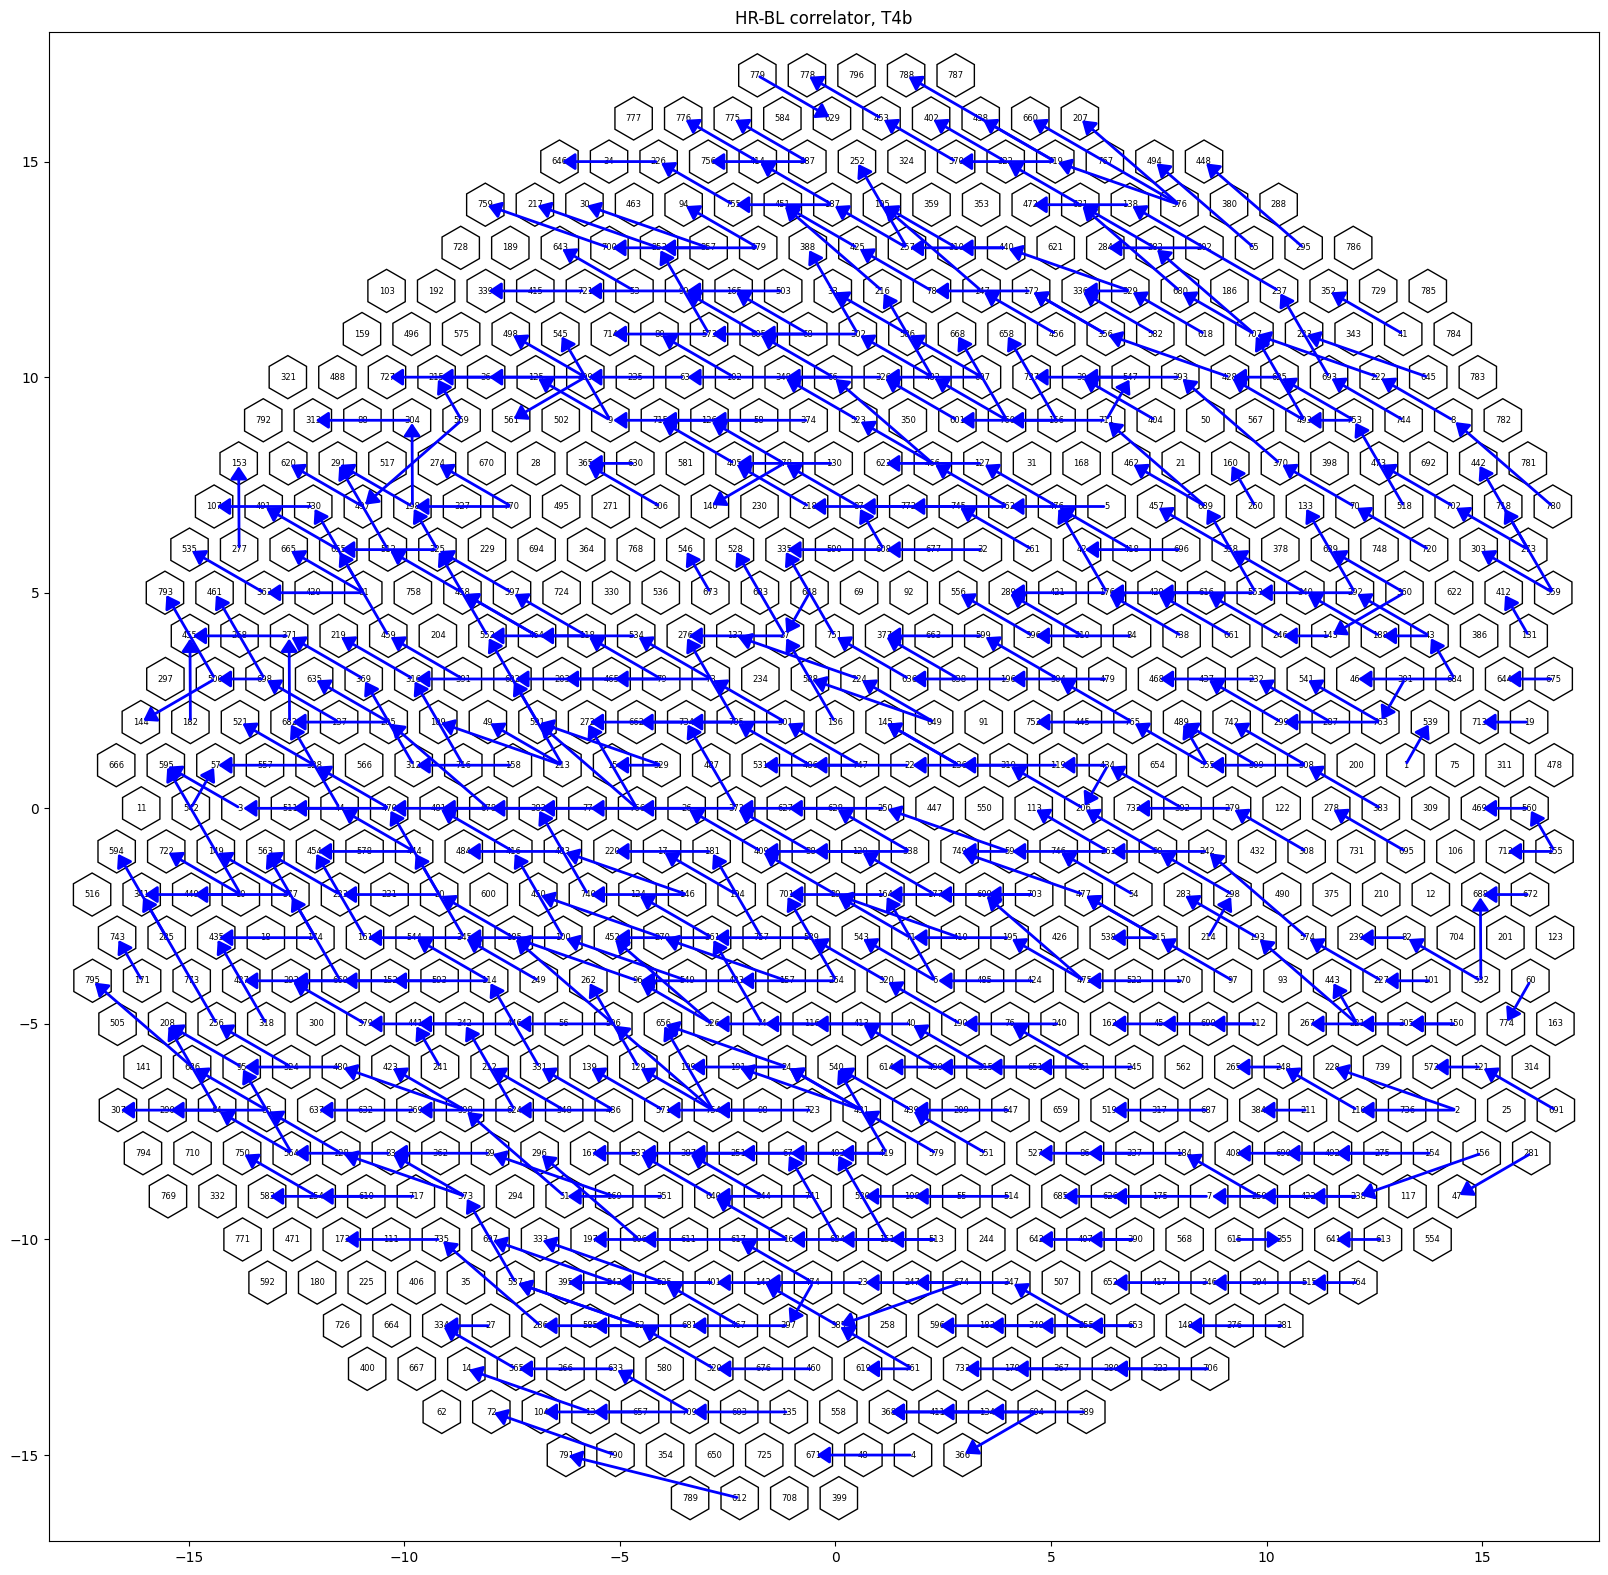

In [184]:
## Plotting on the 2D lattice: look at the reference axis (h, v, p, q) 
new_p_values = new_centered_p_values
fig, ax, hexagons = plot_hex_grid(new_p_values, original_q, hex_size=0.5, spacing=0.5, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition
new_p_x_ls = []
for p_x, p_y in p:
    color_in_p = p_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = p_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('g')
            new_p_x_ls.append(new_p_pos[0])
            
new_q_x_ls = []
for q_x, q_y in q:
    color_in_p = q_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = q_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('c')
            new_q_x_ls.append(new_p_pos[0])
            
new_h_x_ls = []
for h_x, h_y in h:
    color_in_p = h_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = h_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('y')
            new_h_x_ls.append(new_p_pos[0])

new_v_x_ls = []
for v_x, v_y in v:
    color_in_p = v_x
    color_in_p = add_space_in_between(18, 18, _space, [color_in_p])
    color_in_p = color_in_p[0]
    color_in_q = v_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(new_p_values, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=_relative_change) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('grey')
            new_v_x_ls.append(new_p_pos[0])


new_180_0_deg_axis = list(zip(new_h_x_ls,h_y_ls)) # This is my reference line to calculate vectors angles.
new_270_90_deg_axis = list(zip(new_v_x_ls,v_y_ls)) # This is my reference line to calculate vectors angles.

# Draw vector from hexagon to hexagon
# Choose column_ids (start and end) based on the expected preferred direction (PD) for a given correlator


if correlator == 'BL':
    start_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.home_column_id.tolist()]
    end_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.BL_column_id.tolist()] 
elif correlator == 'HR':
    start_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.HR_column_id.tolist()]
    end_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.home_column_id.tolist()]  
elif correlator == 'HR-BL':
    start_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.HR_column_id.tolist()]
    end_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.BL_column_id.tolist()]  

    
start_coords_ls = []
end_coords_ls = []
for start_id, end_id in zip(start_ids, end_ids):
    start_id_p = df_grid[df_grid.column_id == str(start_id)].new_p.values[0]
    start_id_p = df_grid[df_grid.column_id == str(start_id)].new_centered_p.values[0]
    start_id_q = df_grid[df_grid.column_id == str(start_id)].q.values[0]
    start_coords_ls.append((start_id_p,start_id_q))

    
    end_id_p = df_grid[df_grid.column_id == str(end_id)].new_p.values[0]
    end_id_p = df_grid[df_grid.column_id == str(end_id)].new_centered_p.values[0]
    end_id_q = df_grid[df_grid.column_id == str(end_id)].q.values[0]
    end_coords_ls.append((end_id_p,end_id_q))

#Drawing vectors
for start_coord, end_coord in zip(start_coords_ls,end_coords_ls):
    # Find the coordinates of the start and end hexagons
    x_start = start_coord[0]
    y_start = start_coord[1]
    
    x_end = end_coord[0]
    y_end = end_coord[1]

    draw_vector(ax, x_start, y_start, x_end, y_end, color=color_dict[to_cell_of_interest])

plt.title(f'{correlator} correlator, {to_cell_of_interest}')
plt.show()

In [182]:
df_grid[df_grid.column_id == '628']

root_id cell_type column_id  p  q  x  y  new_p  new_centered_p
639  720575940632856289       Mi1       628  0  0  0  0  -9.28             0.0

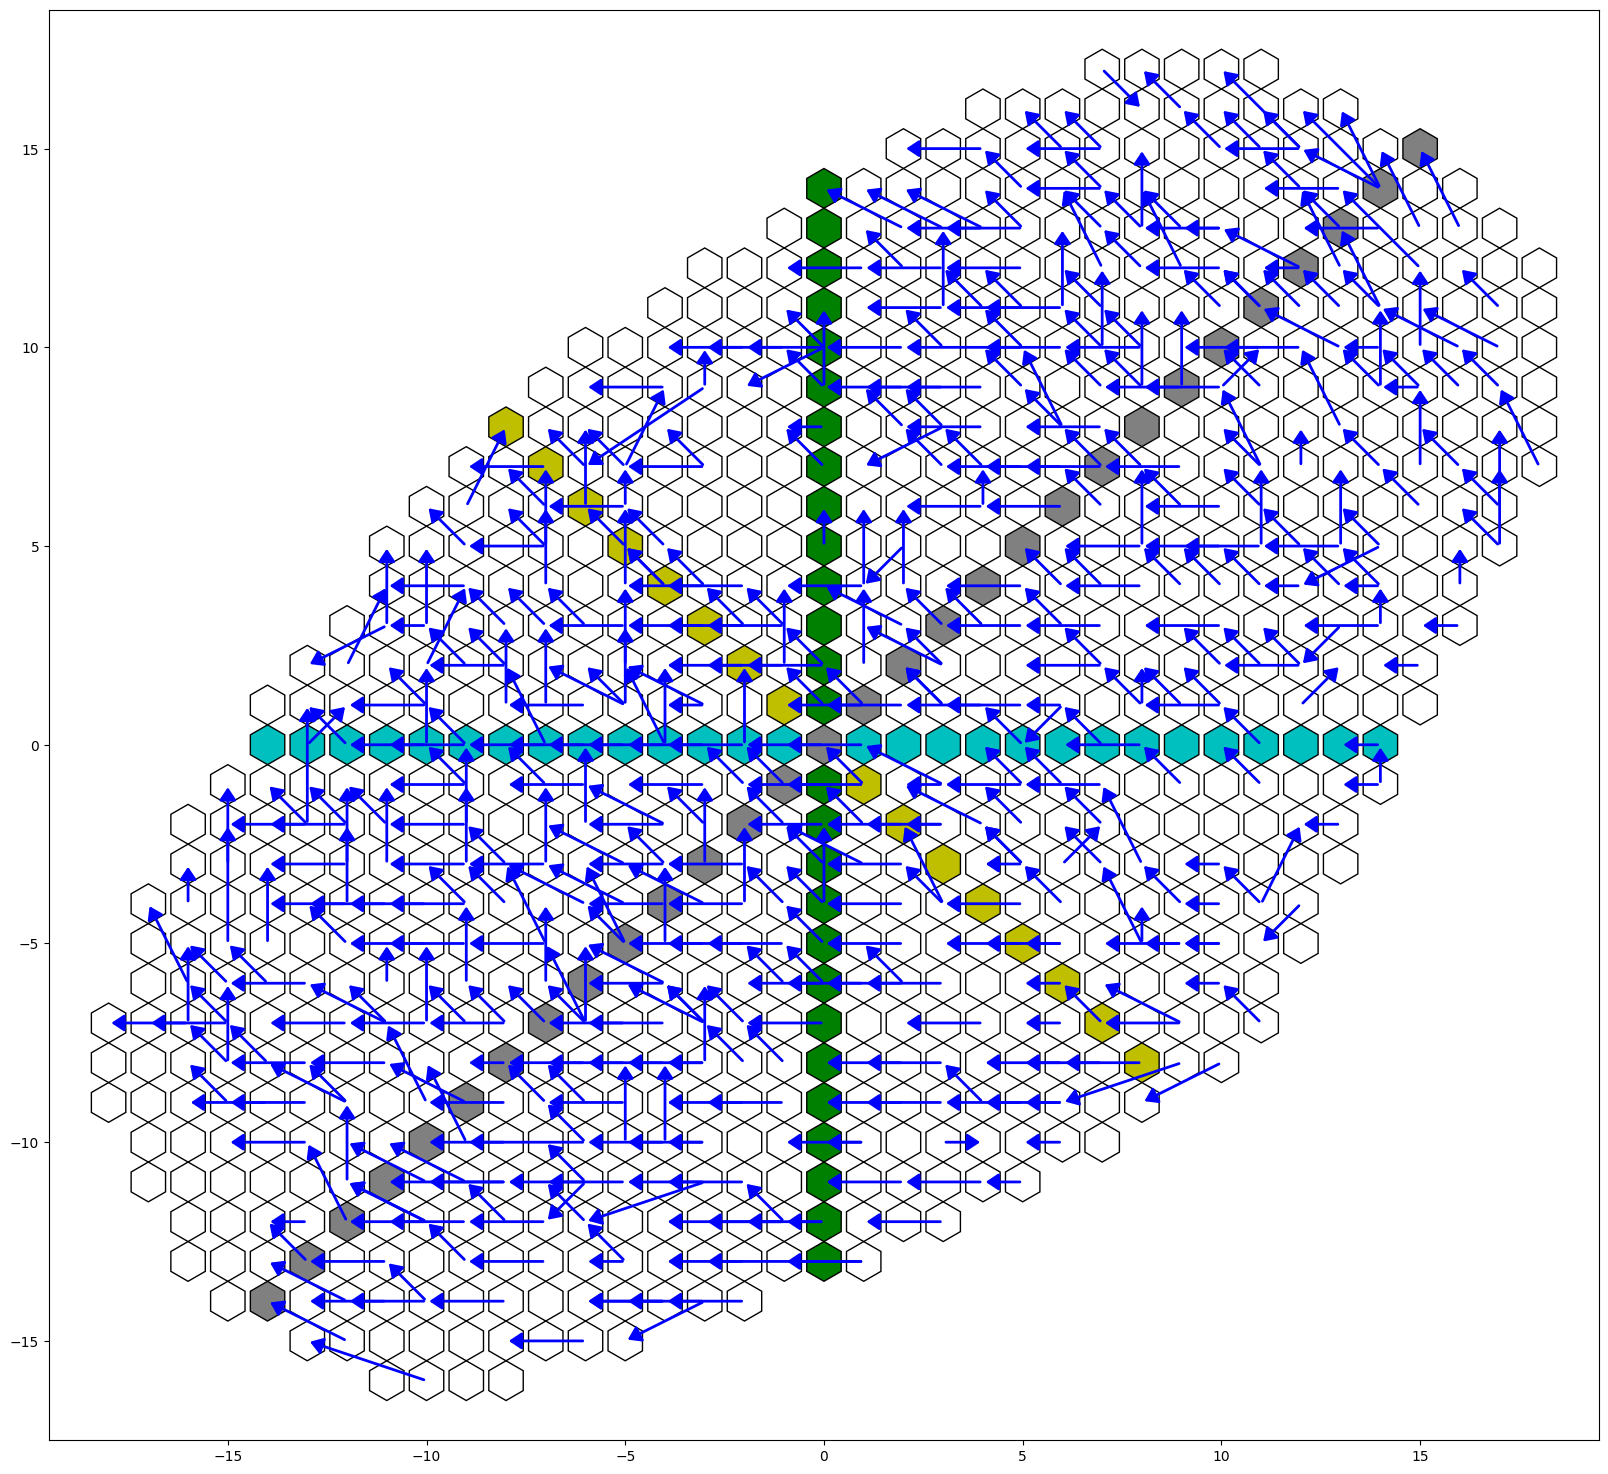

In [151]:
## Plotting on the 2D lattice: check access to each point and axis
fig, ax, hexagons = plot_hex_grid(original_p, original_q, hex_size=0.5, spacing=1.0, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition
for p_x, p_y in p:
    color_in_p = p_x
    color_in_q = p_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('g')

for q_x, q_y in q:
    color_in_p = q_x
    color_in_q = q_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('c')
            

for h_x, h_y in h:
    color_in_p = h_x
    color_in_q = h_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('y')


for v_x, v_y in v:
    color_in_p = v_x
    color_in_q = v_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('grey')
            


#Preparing the vectors to draw
if correlator == 'BL':
    start_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.home_column_id.tolist()]
    end_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.BL_column_id.tolist()] 
elif correlator == 'HR':
    start_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.HR_column_id.tolist()]
    end_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.home_column_id.tolist()]  
elif correlator == 'HR-BL':
    start_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.HR_column_id.tolist()]
    end_ids = [int(x) for x in HR_BL_unique_highest_inputs_filtered.BL_column_id.tolist()]  


start_coords_ls = []
end_coords_ls = []
for start_id, end_id in zip(start_ids, end_ids):
    start_id_p = df_grid[df_grid.column_id == str(start_id)].p.values[0]
    start_id_q = df_grid[df_grid.column_id == str(start_id)].q.values[0]
    start_coords_ls.append((start_id_p,start_id_q))

    
    end_id_p = df_grid[df_grid.column_id == str(end_id)].p.values[0]
    end_id_q = df_grid[df_grid.column_id == str(end_id)].q.values[0]
    end_coords_ls.append((end_id_p,end_id_q))

#Drawing vectors
for start_coord, end_coord in zip(start_coords_ls,end_coords_ls):
    # Find the coordinates of the start and end hexagons
    x_start = start_coord[0]
    y_start = start_coord[1]
    
    x_end = end_coord[0]
    y_end = end_coord[1]
    
    draw_vector(ax, x_start, y_start, x_end, y_end, color=color_dict[to_cell_of_interest])


plt.title(f'{correlator} correlator, {to_cell_of_interest}')
plt.show()

In [152]:
# Prepare the list for angles
angles = []

# Calculate the angle for each vector
for start_id, end_id, start_coord, end_coord in zip(start_ids, end_ids, start_coords_ls, end_coords_ls):
    # Coordinates
    x_start, y_start = start_coord
    x_end, y_end = end_coord
    
    # Calculate the change in coordinates
    dx = x_end - x_start
    dy = y_end - y_start
    
    # Calculate the angle in radians
    angle_rad = np.arctan2(dy, dx)
    
    # Convert to degrees
    angle_deg = np.degrees(angle_rad)
    
    # Normalize the angle to be in the range [0, 360) degrees
    angle_deg = (angle_deg + 360) % 360
    
    # Append the result to the angles list
    angles.append((start_id, end_id, angle_deg))

# Create a DataFrame with the results
angles_df = pd.DataFrame(angles, columns=['start_id', 'end_id', 'angle'])



In [153]:
# Define the angle of the diagonal line y = -x
# The angle of y = -x is -45 degrees (or -π/4 radians)
diagonal_angle_rad = np.radians(-45)

# Prepare the list for angles
angles = []

# Calculate the angle for each vector
for start_id, end_id, start_coord, end_coord in zip(start_ids, end_ids, start_coords_ls, end_coords_ls):
    # Coordinates
    x_start, y_start = start_coord
    x_end, y_end = end_coord
    
    # Calculate the change in coordinates
    dx = x_end - x_start
    dy = y_end - y_start
    
    # Calculate the angle in radians relative to the x-axis
    angle_rad = np.arctan2(dy, dx)
    
    # Adjust the angle relative to the diagonal line y = -x
    adjusted_angle_rad = angle_rad - diagonal_angle_rad
    
    # Convert to degrees
    adjusted_angle_deg = np.degrees(adjusted_angle_rad)
    
    # Normalize the angle to be in the range [0, 360) degrees
    adjusted_angle_deg = (adjusted_angle_deg + 360) % 360
    
    # Append the result to the angles list
    angles.append((start_id, end_id, adjusted_angle_deg))

# Create a DataFrame with the results
angles_df = pd.DataFrame(angles, columns=['start_id', 'end_id', 'angle'])

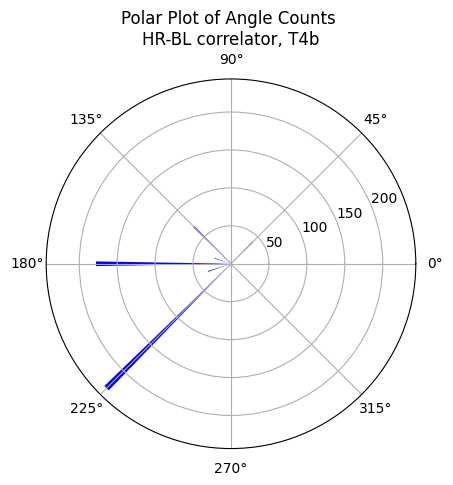

In [159]:
## Plotting frequency

# Drop NaN values from angles
angles_df = angles_df.dropna(subset=['angle'])

# Count the occurrences of each unique angle
angle_counts = angles_df['angle'].value_counts().reset_index()
angle_counts.columns = ['angle', 'count']

# Convert angles to radians
angle_counts['angle_rad'] = np.radians(angle_counts['angle'].values)

# Plotting
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the counts at the corresponding angles
ax.bar(angle_counts['angle_rad'], angle_counts['count'], width=np.pi/90, bottom=0.0, color = color_dict[to_cell_of_interest])

ax.set_title("Polar Plot of Angle Counts")
plt.title(f'Polar Plot of Angle Counts \n{correlator} correlator, {to_cell_of_interest}')
plt.show()

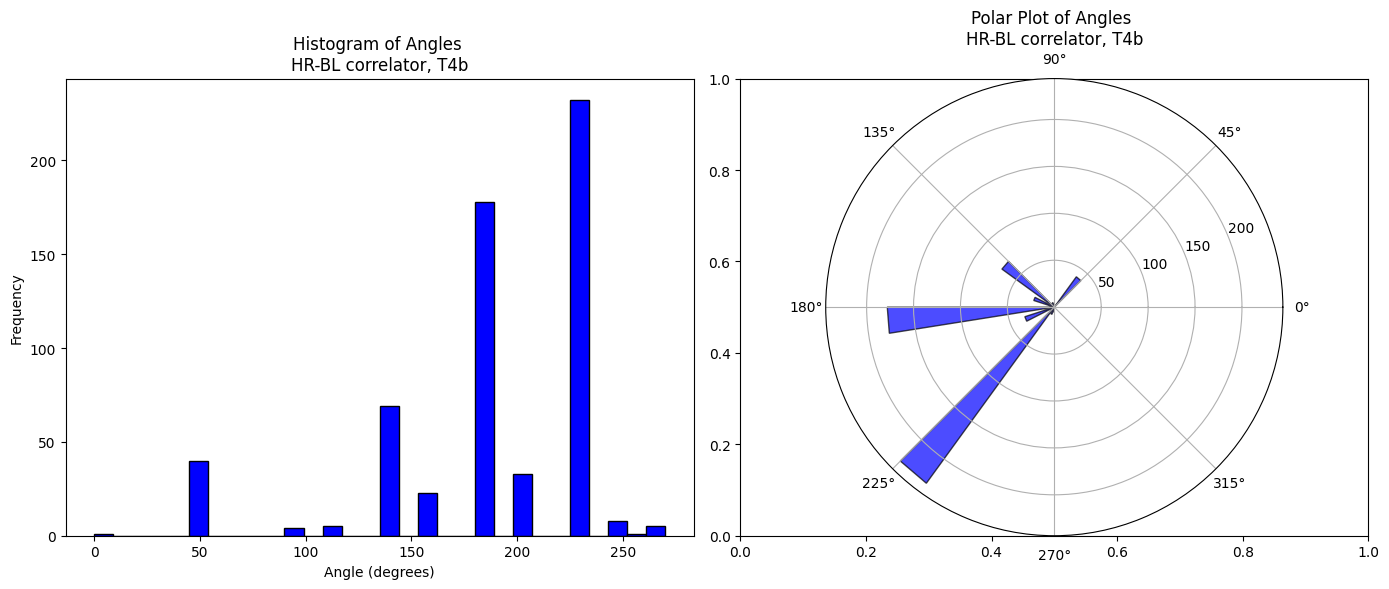

In [161]:
## Looking at distributions

# Data
angles = angles_df['angle']

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histogram Plot
axs[0].hist(angles, bins=30, edgecolor='black', color=color_dict[to_cell_of_interest])
axs[0].set_title(f'Histogram of Angles \n{correlator} correlator, {to_cell_of_interest}')
axs[0].set_xlabel('Angle (degrees)')
axs[0].set_ylabel('Frequency')

# Polar Plot
angles_rad = np.radians(angles)  # Convert angles to radians
axs[1] = plt.subplot(122, projection='polar')
axs[1].hist(angles_rad, bins=30, density=False, edgecolor='black', color=color_dict[to_cell_of_interest], alpha=0.7, histtype='stepfilled')
axs[1].set_title(f'Polar Plot of Angles \n{correlator} correlator, {to_cell_of_interest}')

# Show plots
plt.tight_layout()
plt.show()

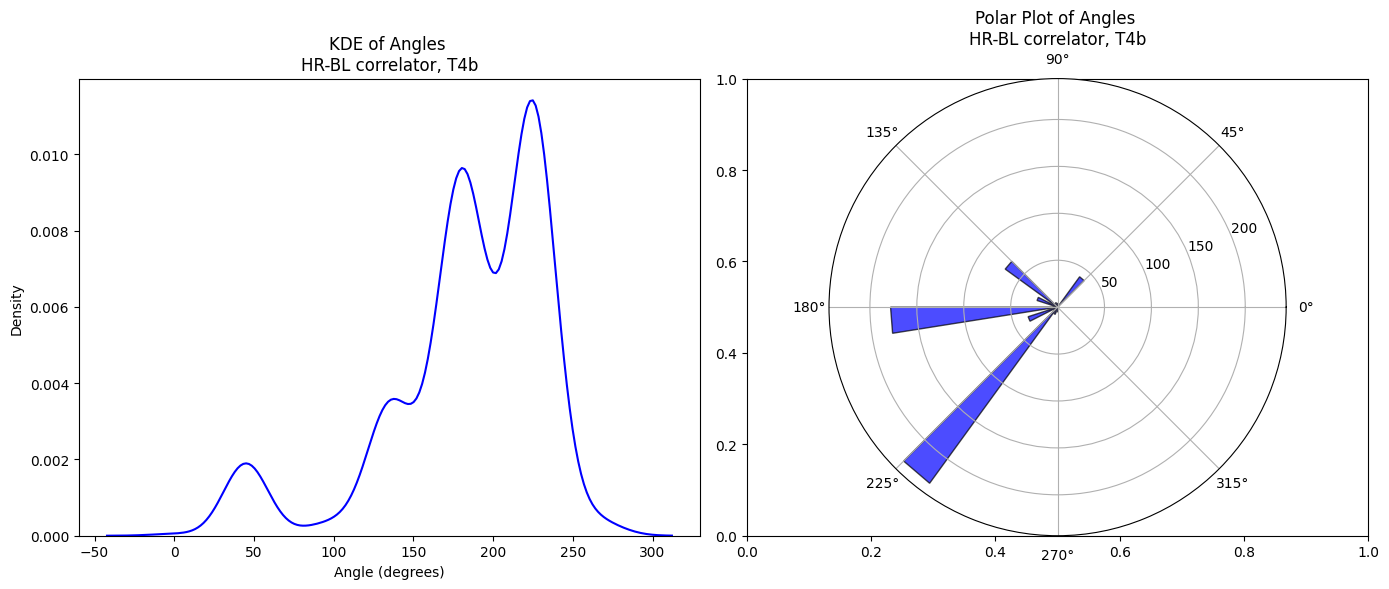

In [162]:
## Looking at distributions

# Data
angles = angles_df['angle']

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# KDE Plot
sns.kdeplot(angles, ax=axs[0], color=color_dict[to_cell_of_interest])
axs[0].set_title(f'KDE of Angles \n{correlator} correlator, {to_cell_of_interest}')
axs[0].set_xlabel('Angle (degrees)')
axs[0].set_ylabel('Density')

# Polar Plot
angles_rad = np.radians(angles)  # Convert angles to radians
axs[1] = plt.subplot(122, projection='polar')
axs[1].hist(angles_rad, bins=30, density=False, edgecolor='black', color=color_dict[to_cell_of_interest], alpha=0.7, histtype='stepfilled')
axs[1].set_title(f'Polar Plot of Angles \n{correlator} correlator, {to_cell_of_interest}')

# Show plots
plt.tight_layout()
plt.show()